# Example Usage

The `SkyScene` object is designed to give you access to many PRFs to make up a field of stars. This will rely on you having `gaiaoffline` installed and the database for `gaiaoffline` downloaded and in the right place.

!!! note "You must ensure you have gaiaoffline database installed"

    You should follow the [`gaiaoffline` documentation](https://christinahedges.github.io/gaiaoffline/) to ensure your database is installed correctly. This database is 30gb, and you should download the approved one from Zenodo or obtain it from a team member.

To create a SkyScene we three things:

1. The PRF: You should load the PRF you want to be used in the scene. You obtain the `PRF` from `pandoraaperture`
2. The WCS: The world coordinate system that we are using. This is determined by where we are pointing. You can obtain the WCS from `pandoraref`
3. The time: Because stars have proper motion we also need the time, to ensure the catalog has the stars in the right position. You should update the time based on when you're observing with Pandora.

We have convenience methods to load PRFs and WCS using `from_pointing` which will take an RA, Dec, and theta for the boresight of the telescope and will then load the right reference products. 

In [1]:
import pandoraaperture as pa
import matplotlib.pyplot as plt
import pandoraref as pr
import numpy as np
from astropy.time import Time

In [2]:
# coordinates for Kepler-10
ra, dec, theta = (285.6794224553767, 50.24130600481639, 85.1230985)

The first kind of `SkyScene` is the base class and is mostly useful for modeling VISDA full frame images.

In [3]:
scene = pa.SkyScene.from_pointing(ra, dec, theta, time=Time.now())

In [4]:
scene

SkyScene

Let's plot the scene. This models the scene using all the flux values in the catalog.

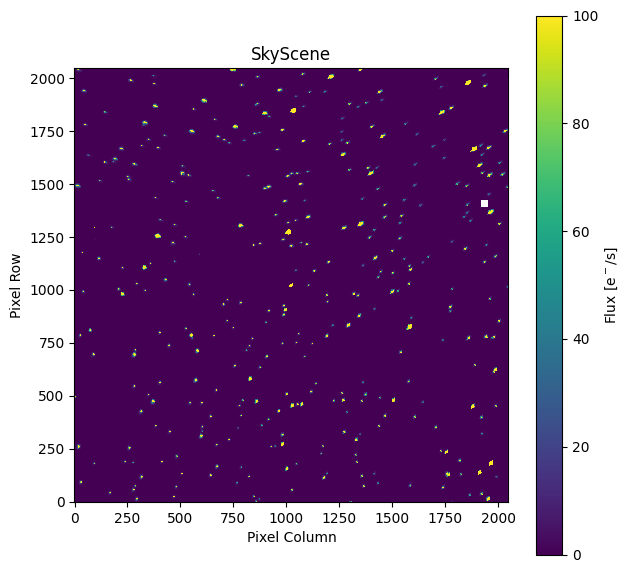

In [5]:
scene.plot();

This looks good, let's take a look at a different kind of SkyScene. 

`ROISkyScene` is for ROIs on the VISDA. The ROIs are specified using their own corners and sizes. 

In [6]:
rR, rC = np.mgrid[-500:500:3j, -500:500:3j]

ROI_corners = [(r + 1024 - 25, c + 1024 - 25) for r, c in zip(rR.ravel(), rC.ravel())]
nROIs = len(ROI_corners)
ROI_size = (50, 50)

In [7]:
scene = pa.ROISkyScene.from_pointing(ra, dec, theta, time=Time.now(), nROIs=nROIs, ROI_size=ROI_size, ROI_corners=ROI_corners)

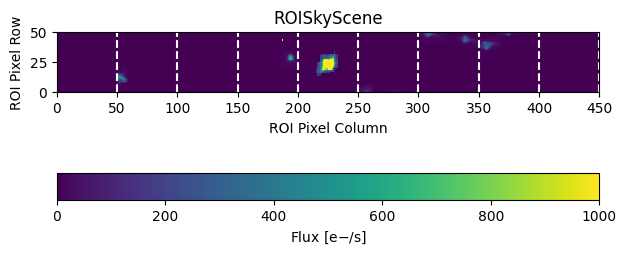

In [8]:
scene.plot(vmax=1000);

This looks good too.

Let's look at the last kind of scene which is the `DispersedSkyScene`. This is primarily for working with NIRDA data.

In [9]:
scene = pa.DispersedSkyScene.from_pointing(ra, dec, theta, time=Time.now())

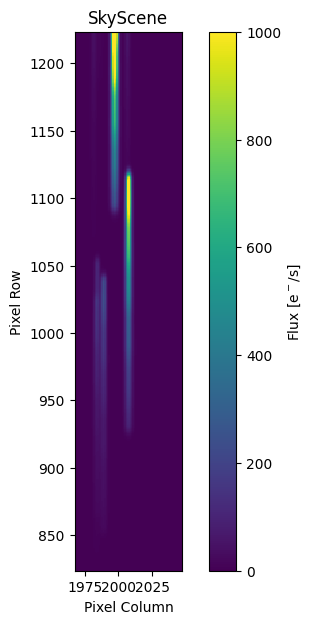

In [10]:
scene.plot(vmax=1000);

All `SkyScene` objects use a PRF, WCS and a catalog of sources to make scenes. Each of these items should be loaded for you by the `SkyScene` object. 

In [11]:
scene.prf

DispersedPRF [836 elements]

In [12]:
scene.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 285.6794224553767 50.24130600481639 
CRPIX : 2008.0 1024.0 
PC1_1 PC1_2  : 0.0850152447048681 -0.9963796506190656 
PC2_1 PC2_2  : 0.9963796506190656 0.0850152447048681 
CDELT : -0.00033055555555555 0.00033055555555556 
NAXIS : 0  0

In [13]:
scene.cat

,RA,Dec,source_id,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,j_flux,h_flux,k_flux,teff_gspphot,row,column
0,285.633757,50.231231,2132155154538128768,56236.210944,31355.100882,35614.164609,1540.991844,1572.679262,985.916266,5941.9517,932.076335,1984.175912
1,285.641149,50.233379,2132155085818652928,203377.545737,116295.538335,125442.543287,5250.496097,5448.0384,3137.90674,6142.2866,946.977576,1989.423698
2,285.647999,50.232176,2132155085818653184,42743.629051,17197.44932,36317.625121,2351.799751,3380.960991,2080.846441,4535.444,959.926878,1984.663866
3,285.679215,50.241604,2132155017099178624,807113.660182,430541.476911,539327.990865,24603.695303,27405.653344,16559.225946,5595.7837,1022.675812,2007.931714
4,285.742462,50.244746,2133655472513199360,44080.19357,24707.747994,27664.001865,1191.791655,1314.135538,776.676262,6050.1006,1144.778601,2007.053184
5,285.742767,50.260734,2133655571295536896,35732.399589,14461.998394,30473.324992,1927.526422,2763.377136,1794.072677,4520.6436,1149.299626,2055.216241
6,285.753612,50.237074,2133655403793722752,32228.636685,16795.400158,22203.38556,1128.756697,1296.104922,826.875325,5807.1235,1164.09432,1982.100156
7,285.764802,50.242807,2133655506872938752,3783886.782239,2558851.50372,1839476.5443,58748.981246,50008.077622,30105.097079,9376.287,1186.870117,1997.569911
8,285.786348,50.264355,2133655713031373184,119057.057927,67003.067235,74566.519233,3169.569944,3421.686056,1981.709686,6014.1904,1233.069802,2059.075354
9,285.815075,50.241934,2133655266354774528,47226.165502,25787.084681,30479.605866,1368.359904,1514.398462,890.922715,5815.2905,1281.980629,1986.803295


The object works by creating a design matrix for you.

This design matrix is a `Sparse3D` object which contains one image per source. When you dot it with the flux values of each source, you get the scene image.


In [15]:
scene.A(delta_pos=(0, 0))

<(400, 80, 10) Sparse3D array of type float64>

Each `SkyScene` has an `evaluate` method which will return the image of the scene.

In [16]:
r, c, im = scene.evaluate()

You can move this scene around with the `delta_pos` argument to shift it by a number of pixels. You should only do this for small shifts.

`SkyScene` objects enable you to build FITS files containing the information you may need for that scene. You can obtain the following files

### Catalog extension

This extension shows what targets are likely to fall on a pixel

In [17]:
hdu = scene.get_catalog_hdu()

In [27]:
hdu.data

FITS_rec([(285.63375713, 50.23123126, '2132155154538128768',   56236.21094419,   31355.10088213,   35614.16460896,  1540.99184352,  1572.67926186,   985.91626641, 5941.9517,  932.07633471, 1984.1759121 , 0, 0),
          (285.64114856, 50.23337889, '2132155085818652928',  203377.54573736,  116295.53833483,  125442.5432872 ,  5250.49609725,  5448.03839999,  3137.90673989, 6142.2866,  946.97757597, 1989.42369778, 0, 0),
          (285.64799857, 50.23217562, '2132155085818653184',   42743.62905105,   17197.44932034,   36317.625121  ,  2351.79975073,  3380.96099121,  2080.8464409 , 4535.444 ,  959.92687784, 1984.66386645, 0, 0),
          (285.67921452, 50.24160376, '2132155017099178624',  807113.66018202,  430541.47691061,  539327.99086458, 24603.69530318, 27405.6533437 , 16559.22594555, 5595.7837, 1022.67581219, 2007.9317141 , 0, 0),
          (285.74246199, 50.24474638, '2133655472513199360',   44080.1935701 ,   24707.74799427,   27664.00186461,  1191.79165461,  1314.13553792,   776.676

### Aperture extension

This extension shows the apertures for a given target. You will need to input the target number to obtain the aperture. You can either use the target index in the catalog, or a SkyCoord to use the target closest to that coordinate.

In [33]:
scene.get_aperture_hdu(1)

In [34]:
from astropy.coordinates import SkyCoord
scene.get_aperture_hdu(SkyCoord(ra, dec, unit='deg'))

### PRF extension

This extension gives you a FITS extension of the PRFs of each source. When combined with the catalog PRF, this gives you all of the information you strictly need for PRF photometry. This does not require a specific target to be input as it gives all PRFs for all possible targets.

In [35]:
scene.get_prf_hdu()

### Model extension

This extension models the whole scene and returns it as an image.

In [39]:
scene.get_model_hdu()